<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695   

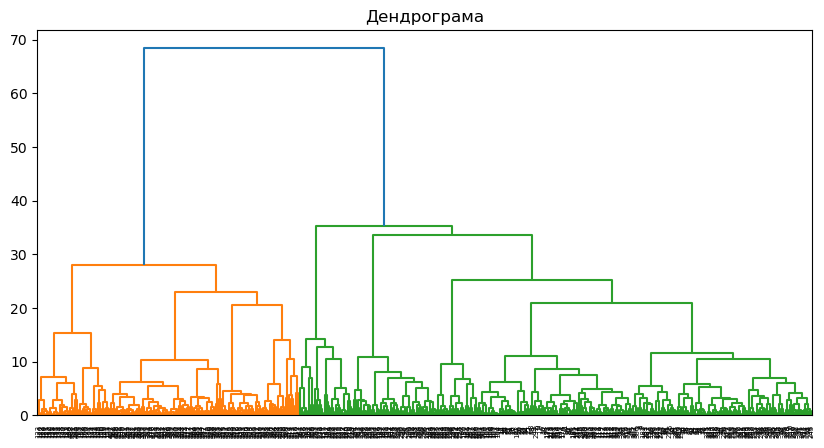

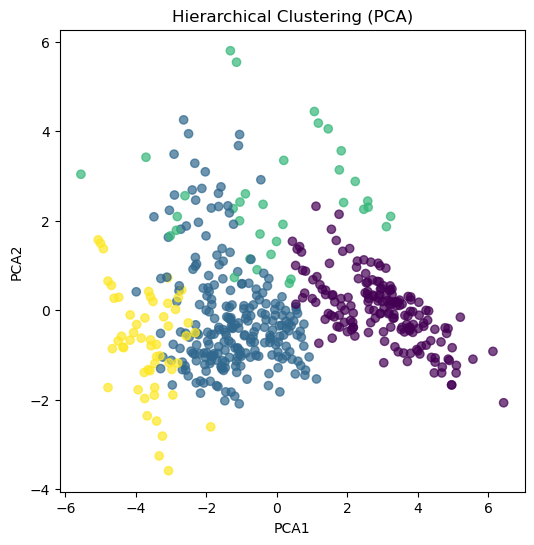

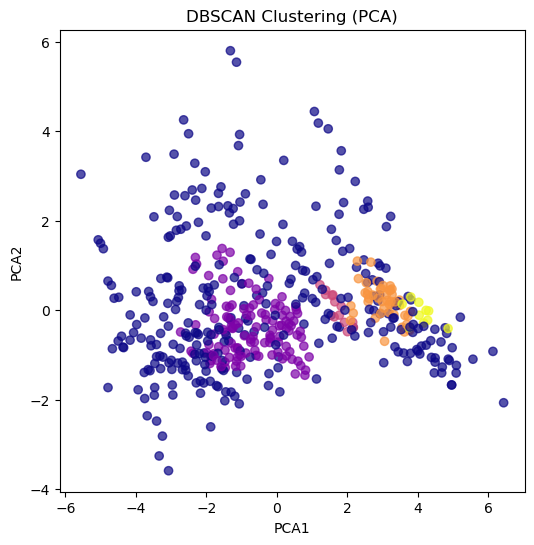

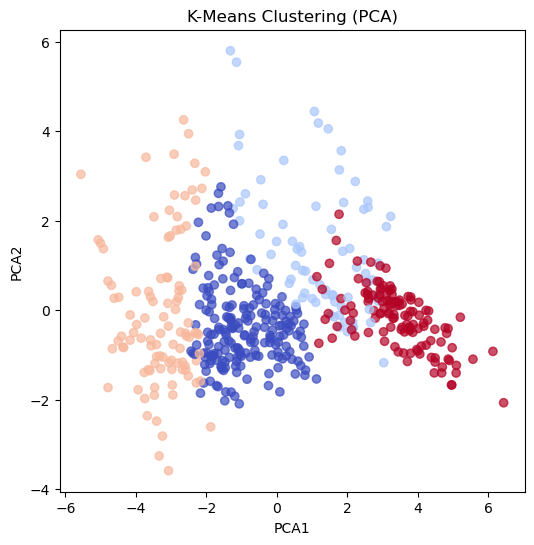

Hierarchical Clustering Silhouette Score: 0.279
Hierarchical Clustering Davies-Bouldin Score: 1.188
DBSCAN Silhouette Score: -0.044
DBSCAN Davies-Bouldin Score: 2.108
K-Means Silhouette Score: 0.259
K-Means Davies-Bouldin Score: 1.605


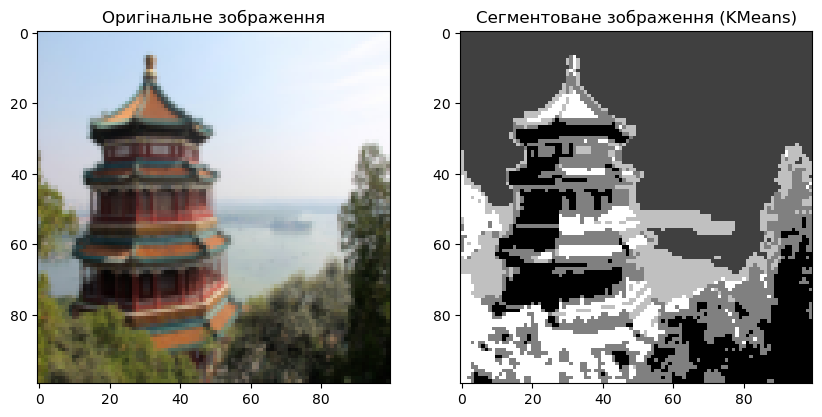

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.datasets import load_sample_image
from skimage.color import rgb2lab
from skimage.util import img_as_float
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Завантаження та підготовка даних
df = pd.read_csv("boston.csv")
print(df.info())
print(df.describe())

# Видалення нечислових стовпців
df = df.select_dtypes(include=[np.number])

# Масштабування даних
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# 2. Ієрархічна кластеризація
linkage_matrix = linkage(df_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Дендрограма")
plt.show()

# Визначення оптимального числа кластерів за допомогою PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

optimal_clusters = 4  # Визначаємо на основі дендрограми
hierarchical_model = AgglomerativeClustering(n_clusters=optimal_clusters)
labels_hierarchical = hierarchical_model.fit_predict(df_scaled)

plt.figure(figsize=(6, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_hierarchical, cmap='viridis', alpha=0.7)
plt.title('Hierarchical Clustering (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# 3. Оптимізація DBSCAN
dbscan_model = DBSCAN(eps=1.2, min_samples=10)
labels_dbscan = dbscan_model.fit_predict(df_scaled)

plt.figure(figsize=(6, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_dbscan, cmap='plasma', alpha=0.7)
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# 4. Додавання K-Means для порівняння
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(6, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans_labels, cmap='coolwarm', alpha=0.7)
plt.title('K-Means Clustering (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# 5. Оцінка якості кластеризації
def evaluate_clustering(labels, name):
    if len(set(labels)) > 1:
        silhouette = silhouette_score(df_scaled, labels)
        davies_bouldin = davies_bouldin_score(df_scaled, labels)
        print(f"{name} Silhouette Score: {silhouette:.3f}")
        print(f"{name} Davies-Bouldin Score: {davies_bouldin:.3f}")
    else:
        print(f"{name} не зміг визначити достатню кількість кластерів.")

evaluate_clustering(labels_hierarchical, "Hierarchical Clustering")
evaluate_clustering(labels_dbscan, "DBSCAN")
evaluate_clustering(kmeans_labels, "K-Means")

# 6. Сегментація зображень методом кластеризації з оптимізацією
image = load_sample_image("china.jpg")
image = img_as_float(image)
image_small = resize(image, (100, 100), anti_aliasing=True)

# Конвертація у LAB-простір
image_lab = rgb2lab(image_small)
image_data = image_lab.reshape(-1, 3)

# Використання KMeans для кластеризації пікселів
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
image_labels = kmeans.fit_predict(image_data)

# Відновлення зображення
segmented_image = image_labels.reshape(image_lab.shape[:2])

# Візуалізація
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_small)
plt.title('Оригінальне зображення')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Сегментоване зображення (KMeans)')
plt.show()
